In [1]:
import pickle
import numpy as np
import matplotlib.pylab as plt
import os
from scipy import interpolate
import torch

from model import LSTM_Model
from util_FPC import EarlyStopping, get_fpc
from train_model import train_model
from import_file import *

In [2]:
# def interp(v, q, num):
#     f = interpolate.interp1d(v,q,kind='linear')
#     v_new = np.linspace(v[0],v[-1],num)
#     q_new = f(v_new)
#     vq_new = np.concatenate((v_new.reshape(-1,1),q_new.reshape(-1,1)),axis=1)
#     return q_new

# n_cyc = 100
# in_stride = 10
# fea_num = 100

# v_low = 3.36
# v_upp = 3.60
# q_low = 610
# q_upp = 1190
# rul_factor = 3000
# cap_factor = 1190
# fea_num =   100

# data_features = []
# for name in os.listdir("./Datasets/our_data")[0:]:
#     name = name[0:-4]
#     bat1 = pickle.load(open(r'./Datasets/our_data/'+name+'.pkl', 'rb'))
#     # list(bat1['1-2']['data'].keys())[9:]
#     A_rul = bat1[name]['rul']
#     A_dq = bat1[name]['dq']
#     A_df = bat1[name]['data']
#     all_idx = list(A_dq.keys())[9:]
#     all_fea, rul_lbl, cap_lbl = [], [], []
#     for cyc in all_idx:
#         tmp = A_df[cyc]
#         tmp = tmp.loc[tmp['Status'].apply(lambda x: not 'discharge' in x)]
        
#         left = (tmp['Current (mA)']<5000).argmax() + 1
#         right = (tmp['Current (mA)']<1090).argmax() - 2

#         tmp = tmp.iloc[left:right]

#         tmp_v = tmp['Voltage (V)'].values
#         tmp_q = tmp['Capacity (mAh)'].values
#         tmp_t = tmp['Time (s)'].values
#         v_fea = interp(tmp_t, tmp_v, fea_num)
#         q_fea = interp(tmp_t, tmp_q, fea_num)

#         tmp_fea = np.hstack((v_fea.reshape(-1,1), q_fea.reshape(-1,1)))
        
#         all_fea.append(np.expand_dims(tmp_fea,axis=0))
#         rul_lbl.append(A_rul[cyc])
        
#         cap_lbl.append(A_dq[cyc])
            
        
        
#     all_fea = np.vstack(all_fea)
#     rul_lbl = np.array(rul_lbl)
#     cap_lbl = np.array(cap_lbl)
    
#     all_fea_c = all_fea.copy()
#     all_fea_c[:,:,0] = (all_fea_c[:,:,0]-v_low)/(v_upp-v_low)
#     all_fea_c[:,:,1] = (all_fea_c[:,:,1]-q_low)/(q_upp-q_low)
#     dif_fea = all_fea_c - all_fea_c[0:1,:,:]
#     all_fea = np.concatenate((all_fea,dif_fea),axis=2)
    

#     data_features.append((all_fea,cap_lbl))
#     # all_fea = np.lib.stride_tricks.sliding_window_view(all_fea,(n_cyc,fea_num,4))
#     # cap_lbl = np.lib.stride_tricks.sliding_window_view(cap_lbl,(n_cyc,))
#     # all_fea = all_fea.squeeze(axis=(1,2,))
#     # rul_lbl = rul_lbl[n_cyc-1:]
#     # all_fea = all_fea[:,(in_stride - 1)::in_stride,:,:]
#     # cap_lbl = cap_lbl[:,(in_stride - 1)::in_stride,]
    
#     # all_fea_new = np.zeros(all_fea.shape)
#     # all_fea_new[:,:,:,0] = (all_fea[:,:,:,0]-v_low)/(v_upp-v_low)
#     # all_fea_new[:,:,:,1] = (all_fea[:,:,:,1]-q_low)/(q_upp-q_low)
#     # all_fea_new[:,:,:,2] = all_fea[:,:,:,2]
#     # all_fea_new[:,:,:,3] = all_fea[:,:,:,3]
#     # print(f'{name} length is {all_fea_new.shape[0]}', 
#     #       'v_max:', '%.4f'%all_fea_new[:,:,:,0].max(),
#     #       'q_max:', '%.4f'%all_fea_new[:,:,:,1].max(),
#     #       'dv_max:', '%.4f'%all_fea_new[:,:,:,2].max(), 
#     #       'dq_max:', '%.4f'%all_fea_new[:,:,:,3].max())
#     # rul_lbl = rul_lbl / rul_factor
#     # cap_lbl = cap_lbl / cap_factor
#     # plt.ylim([0.85, 1.25])
#     plt.plot(cap_lbl/cap_factor)
#     plt.xlabel("Cycles")
#     plt.ylabel("Discharge capacity (Ah)")

In [3]:
# np.save("Datasets/snl_data.npy", np.array(data_features), allow_pickle=True)
discharge_capacities_SNL = np.load("./Datasets/snl_data.npy",allow_pickle=True)

discharge_capacities_SNL[0][0].shape
d = []
for battery_temp in discharge_capacities_SNL:
    a = np.squeeze(battery_temp[0], axis = 1)     # Voltage/Current Features
    b = np.expand_dims(battery_temp[1], axis =1)  # Discharge Capccity
    c = np.concatenate((b,a), axis =1).T
    d.append(c)

discharge_capacities_SNL = d

In [37]:
from torch.utils.data import Dataset, DataLoader
from dataloader import battery_dataloader
def get_data_SNL(discharge_capacities,percentage,window_size,stride,channels,type):

    train_data =[]
    FPC_data  =[]
    name = 0
    test_data = []
    FPC_data_dict ={}
    test_data_dict = {}
    if(type == "train"):
        
        for battery in discharge_capacities:
 
            battery = np.asarray([battery[i] for i in channels])
            battery_name = 'battery' + str(name)
            FPC_data_dict[battery_name] =[]
            name = name+1
            
            # Taking inital x% as input and giving the output as 1
            i= 0
            target = 1
            while(i+stride+window_size <= int(percentage*len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                train_data.append((battery[:,i:i+window_size], target,battery_name ))
                i = i+stride

            # Taking inputs in the middle for FPC
            i = int(percentage*len(battery[0]))
            target = -1
            while(i+stride+window_size <= int((1-percentage)*len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                FPC_data.append((battery[:,i:i+window_size], target,battery_name))
                FPC_data_dict[battery_name].append(torch.tensor(battery[:,i:i+window_size]).float())
                i = i+stride

            # Taking last x% as input and giving the output as 0
            i = int((1-percentage)*len(battery[0]))
            target = 0
            while(i+stride <= len(battery[0]) and len(battery[0][i:i+window_size]) == window_size):
                train_data.append((battery[:,i:i+window_size], target ,battery_name))
                i = i+stride
            # print(len(FPC_data)-a, len(battery[0]), len(FPC_data)-a- .90*len(battery[0]))

        return train_data,FPC_data,FPC_data_dict

    else:
        name = 70
        for battery in discharge_capacities:
            
            battery = np.asarray([battery[i] for i in channels])
            i= 0
            battery_name = 'battery' + str(name)
            test_data_dict[battery_name] =[]
            name = name+1
            while(i+stride <= len(battery[0]) and len(battery[0][i:i+window_size]) == window_size):
                test_data.append((battery[:,i:i+window_size], 1,battery_name))
                test_data_dict[battery_name].append(torch.tensor(battery[:,i:i+window_size]).float())
                i = i+stride

        return test_data,test_data_dict
    


def get_change_indices(model,discharge_capacities,channels,get_saved_indices, version):

    changes_train = []
    changes_test = []
    epochs = 50
    # os.mkdir("/kaggle/working/change_indices")

    ch = ''.join(map(str,channels))
    if(not get_saved_indices):
            
        for channels in [channels]: 
            print("Channels used : ", channels)
            percentage  = 0.10  # 5 percent data
            window_size = 50    # window size
            stride = 1          # stride
            
            train_data,FPC_data,FPC_data_dict = get_data_SNL(discharge_capacities[0:70],percentage,window_size,stride,channels,type = "train")
            test_data,test_data_dict  = get_data_SNL(discharge_capacities[70:],None,window_size,stride,channels,type= "test")
            
            obj_train  = battery_dataloader(train_data)
            obj_FPC  = battery_dataloader(FPC_data)
            obj_test  = battery_dataloader(test_data)

            train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
            FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
            test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)

            print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)
    

            batteries_train =[i for i in range (5)]
            batteries_test= [70+i for i in range(0,7)]

           
            change_percentage_train, change_indices_train =  get_fpc(model,batteries_train,discharge_capacities,FPC_data_dict,False, False,True,"")
            change_percentage_test, change_indices_test =  get_fpc(model,batteries_test,discharge_capacities,test_data_dict,False, False,False,"")

            

            changes_train.append(np.mean(change_percentage_train))
            changes_test.append(np.mean(change_percentage_test))

            print("Mean FPC for Training is {}and Test is {} :".format(np.mean(changes_train), np.mean(changes_test)))
            
            
            if(os.path.exists("./change_indices") == False):
                os.mkdir("./change_indices")

            np.save(f"./change_indices/change_indices_SNL_train_{ch}_version{version}.npy",change_indices_train, allow_pickle=True)
            np.save(f"./change_indices/change_indices_SNL_test_{ch}_version{version}.npy",change_indices_test, allow_pickle=True)

            np.save(f"./change_indices/change_percentage_SNL_train_{ch}_version{version}.npy",change_percentage_train, allow_pickle=True)
            np.save(f"./change_indices/change_percentage_SNL_test_{ch}_version{version}.npy",change_percentage_test, allow_pickle=True)

    else:
        print("Loading Old Indices")
        change_indices_train = np.load(f"./change_indices/change_indices_SNL_train_{ch}_version{version}.npy" , allow_pickle=True)
        change_indices_test = np.load(f"./change_indices/change_indices_SNL_test_{ch}_version{version}.npy",allow_pickle=True)
        
        change_percentage_train = np.load(f"./change_indices/change_percentage_SNL_train_{ch}_version{version}.npy",allow_pickle=True)
        change_percentage_test = np.load(f"./change_indices/change_percentage_SNL_test_{ch}_version{version}.npy",allow_pickle=True)

        print("Mean FPC for Training is {}and Test is {}".format(np.mean(change_percentage_train), np.mean(change_percentage_test)))

    return change_indices_train, change_indices_test, change_percentage_train, change_percentage_test


    

In [15]:
percentage  = 0.10  # 10 percent data
window_size = 50    # window size
stride = 1          # stride
channels  =[0,1,2,3,4] # channels


train_data_SNL, FPC_data_SNL, FPC_data_dict_SNL= get_data_SNL(discharge_capacities_SNL[0:70], 
                                                              percentage, window_size , stride, channels, "train")
test_data_SNL,test_data_dict_SNL  = get_data_SNL(discharge_capacities_SNL[70:],None,window_size,stride,channels,type= "test")


In [16]:
obj_train_SNL  = battery_dataloader(train_data_SNL)
obj_FPC_SNL  = battery_dataloader(FPC_data_SNL)
obj_test_SNL  = battery_dataloader(test_data_SNL)

train_dataloader_SNL = DataLoader(obj_train_SNL, batch_size=8,shuffle=True)
FPC_dataloader_SNL   = DataLoader(obj_FPC_SNL,batch_size=1,shuffle=False)
test_dataloader_SNL = DataLoader(obj_test_SNL, batch_size=1,shuffle=False)


In [17]:
print("Shape of a batch    :",next(iter(FPC_dataloader_SNL))[0].shape)

Shape of a batch    : torch.Size([1, 5, 50])


In [18]:

device = "cpu"
epochs = 1
learning_rate = 0.01

pretrained = False
load_pretrained = False
version = 1

ch = ''.join(map(str,channels))

# model = CNN_Model(window_size,len(channels))
model = LSTM_Model(window_size,len(channels))

model_dir = "./Weights/FPC/"
model_path = f'{model_dir}/model_SNL_f{ch}_f{window_size}_f{model.name}_f{version}.pth'

if(load_pretrained):
    model.load_state_dict(torch.load(model_path, map_location=device ))

model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas= (0.9, 0.99))
criterion = nn.BCELoss()

early_stopping = EarlyStopping(patience=20)


if(pretrained):
    
    model.load_state_dict(torch.load(model_path, map_location=device ))
    model.to(device)
else:
    model = train_model(model, optimizer, criterion, early_stopping,train_dataloader_SNL,epochs,learning_rate,load_pretrained,model_path,version)

version = 2
# Get Change Indices


Loss = 0.6937876557899002 Accuarcy =0.5020290017127991


In [ ]:
for data in train_dataloader_SNL:
    print(data)
    exit()

<Figure size 432x288 with 0 Axes>

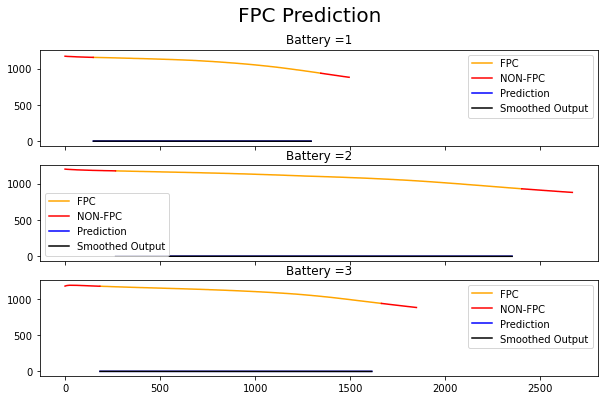

In [39]:
batteries = [i for i in range(0,3)]
_,_ = get_fpc(model,batteries,discharge_capacities_SNL,FPC_data_dict_SNL,True, True,True,"Outputs/FPC_Training_SNL")

In [38]:
change_indices_train,change_indices_test, _, _ = get_change_indices(model,discharge_capacities_SNL,channels,get_saved_indices = False, version = 1)
change_indices_all = np.concatenate((change_indices_train,change_indices_test))

Channels used :  [0, 1, 2, 3, 4]
Shape of a batch    : torch.Size([8, 5, 50])
Mean FPC for Training is 84.53056956643795and Test is 74.56136361794758 :


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

77